<a href="https://colab.research.google.com/github/Rufino086/Atividade-Aula-06-Organizador-de-arquivos-/blob/main/Exerc%C3%ADcios_MLP_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Implementando um MLP com TensorFlow

## Introdução ao TensorFlow e ao MLP

O TensorFlow é uma das bibliotecas mais populares para construir e treinar redes neurais.
Ela fornece uma interface de alto nível chamada **Keras**, que facilita a criação de modelos como o MLP (Multilayer Perceptron).

Um MLP é uma rede formada por múltiplas camadas de neurônios artificiais — uma camada de entrada,
camadas ocultas e uma camada de saída.
Cada camada é totalmente conectada à próxima, e os pesos são ajustados durante o treinamento
por meio do algoritmo de retropropagação e do gradiente descendente.


In [28]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## O conjunto de dados MNIST

O **MNIST** é um dos conjuntos de dados mais clássicos no estudo de redes neurais.  
Ele contém **70.000 imagens de dígitos manuscritos** (de 0 a 9), sendo **60.000 para treino** e **10.000 para teste**.

Cada imagem tem:
- **28 × 28 pixels**, totalizando **784 pontos**;
- Tons de cinza variando de 0 (preto) a 255 (branco);
- Um **rótulo (label)** indicando qual número a imagem representa.

---

### Por que esse conjunto é importante?

O MNIST é um ótimo ponto de partida porque:
- É pequeno e fácil de processar;
- Permite treinar rapidamente modelos simples como o **MLP**;
- Mostra de forma intuitiva como a rede aprende a reconhecer **padrões visuais**.

---

### Pré-processamento dos dados

As redes neurais trabalham melhor com valores **normalizados** (em faixas pequenas, como de 0 a 1).  
Por isso, dividimos todos os pixels por 255, para que fiquem dentro dessa escala.

Além disso, o **MLP espera vetores como entrada**, e não matrizes bidimensionais.  
Como cada imagem tem 28×28 pixels, precisamos **“achatar” (flatten)** a matriz em um vetor de 784 posições:

```python
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)
```

Esse processo **não altera as informações da imagem**, apenas muda sua forma para que cada pixel seja tratado como uma **característica (feature)** de entrada.

---

### Formato final dos dados

Após o achatamento:
- Cada imagem é representada por **784 números** (intensidades dos pixels);
- Cada número indica “o quanto de luz” há naquela posição da imagem;
- Assim, o modelo pode usar esses valores como variáveis de entrada para aprender os padrões que caracterizam cada dígito.

Esse formato é ideal para redes como o **Perceptron Multicamadas (MLP)**, que operam sobre vetores de atributos em vez de estruturas bidimensionais como imagens.


In [29]:

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalização
x_train = x_train / 255.0
x_test = x_test / 255.0

# Flatten
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

print("Formato dos dados de treino:", x_train.shape)


Formato dos dados de treino: (60000, 784)


## Visualizando uma imagem do MNIST e o processo de achatamento

Antes de passarmos para o modelo, vamos **visualizar uma imagem real do MNIST** e entender o que significa "achatar" a matriz 28×28 em um vetor de 784 valores.

Cada imagem no MNIST é uma **matriz bidimensional**, onde cada posição representa a **intensidade do pixel** (entre 0 e 255).

Ao achatar a imagem, transformamos essa matriz em uma **sequência linear de números**, para que o MLP consiga processar cada pixel como uma *entrada independente*.

O código abaixo mostra esse processo visualmente:

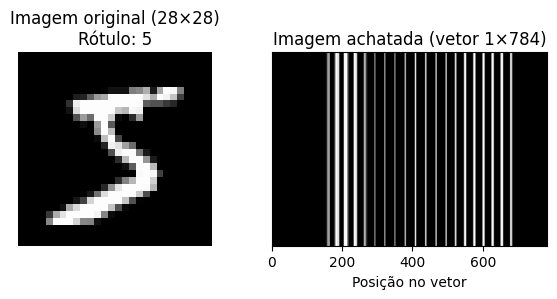

Primeiros 20 valores do vetor achatado:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [30]:
# Carregando o conjunto de dados MNIST
(x_tr_plot, y_tr_plot), (x_ts_plot, y_ts_plot) = keras.datasets.mnist.load_data()

# Seleciona uma imagem qualquer do conjunto de treino
idx = 0
imagem = x_tr_plot[idx]
rotulo = y_tr_plot[idx]
# Achata a imagem (flatten)
vetor = imagem.flatten()

# Figura 1: imagem original 28x28
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(imagem, cmap='gray')
plt.title(f"Imagem original (28×28)\nRótulo: {rotulo}")
plt.axis('off')

# Parte 2: imagem achatada (vetor visual)
plt.subplot(1,2,2)
plt.imshow(vetor[np.newaxis, :], cmap='gray', aspect='auto')
plt.title("Imagem achatada (vetor 1×784)")
plt.yticks([])
plt.xlabel("Posição no vetor")
plt.tight_layout()
plt.show()

# Exibe os primeiros valores do vetor achatado
print("Primeiros 20 valores do vetor achatado:")
print(vetor[:20])


### O que esse código mostra

1. **Imagem original (28×28):** matriz bidimensional com as intensidades dos pixels.  
2. **Imagem achatada (1×784):** a mesma imagem transformada em um vetor unidimensional, que é o formato de entrada esperado pelo MLP.  
3. Cada **quadradinho** no vetor corresponde exatamente a um **pixel** da imagem original, apenas reorganizado em sequência.  

O achatamento não altera as informações — ele apenas muda o formato para que a rede possa processar os dados como uma lista de valores de entrada.

## Construindo o modelo MLP

Agora que os dados estão prontos, vamos criar o nosso modelo de rede neural.  
Usaremos a **API `Sequential`** do Keras, que é a forma mais simples de empilhar camadas em sequência — da entrada até a saída.

A ideia é que os dados entrem pela primeira camada (entrada), passem por uma ou mais camadas ocultas e cheguem à camada de saída, onde será feita a previsão final.

---

### Passo a passo da construção

```python
model = models.Sequential([
    layers.Input(shape=(784,)),            # 28x28 = 784 pixels (camada de entrada)
    layers.Dense(32, activation='relu'),  # Primeira camada oculta
    layers.Dense(32, activation='tanh'),   # Segunda camada oculta
    layers.Dense(128, activation='sigmoid'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(10, activation='softmax')
])
```


In [31]:

model = models.Sequential([
    layers.Input(shape=(784,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(128, activation='sigmoid'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(10, activation='softmax')
])

model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,858 (136.16 KB)

 Trainable params: 34,858 (136.16 KB)

 Non-trainable params: 0 (0.00 B)

### Explicando cada parte

**`models.Sequential([...])`**  
Cria um modelo onde as camadas são empilhadas de forma linear — a saída de uma camada é automaticamente a entrada da próxima.  
Essa é a estrutura mais comum para redes *feedforward* como o MLP.

**`layers.Input(shape=(784,))`**  
Define o formato dos dados de entrada.  
No MNIST, cada imagem é 28×28 pixels, e aqui ela foi achatada (*flattened*) em um vetor de 784 posições.

**`layers.Dense(units, activation='relu')`**  
Cria uma camada totalmente conectada (*fully connected*).  
- `units` indica o número de neurônios (aqui usamos 128 e depois 64).  
- `activation='relu'` aplica a função **ReLU (Rectified Linear Unit)**, que substitui valores negativos por zero e ajuda a rede a aprender relações não lineares.

**`layers.Dense(10, activation='softmax')`**  
Cria a camada de saída com **10 neurônios** (um para cada dígito, de 0 a 9).  
A função *softmax* converte as saídas em probabilidades que somam 1, permitindo interpretar qual dígito o modelo acredita ser mais provável.

---

Por fim, podemos visualizar o resumo da arquitetura com:

```python
model.summary()
```

Isso exibe a estrutura da rede e o número total de parâmetros treináveis em cada camada.

## Compilando o modelo

Antes de treinar a rede, precisamos **compilar** o modelo.  
Isso significa dizer ao TensorFlow como ele deve aprender a partir dos dados.

Durante a compilação, definimos três informações principais:

1. **Como a rede aprende** – ou seja, qual o método será usado para ajustar os pesos (isso é controlado pelo otimizador).  
2. **Como medir o erro** – uma função que indica o quanto as previsões da rede estão diferentes dos valores reais.  
3. **Quais métricas acompanhar** – por exemplo, a acurácia, que mostra o percentual de acertos.

Mesmo sem entrar em detalhes matemáticos agora, o importante é entender que essa etapa prepara o modelo para o aprendizado, dizendo *o que ele deve minimizar* (o erro) e *como acompanhar o desempenho*.

```python
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
```

O comando acima apenas define essas instruções.  
O verdadeiro processo de aprendizado ocorrerá no momento do **treinamento**, quando o modelo ajustará os pesos a partir dos exemplos.


In [32]:

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


## Treinando o modelo

Agora que o modelo foi compilado, podemos **treiná-lo**.  
É nesse momento que a rede começa a aprender a reconhecer padrões nos dados.

Durante o treinamento, o TensorFlow envia os exemplos de entrada (as imagens do conjunto de treino) para o modelo e compara as previsões feitas com os valores reais (os dígitos corretos).  
Com base nessa diferença, ele ajusta os pesos internos da rede para reduzir o erro — esse processo é conhecido como **retropropagação** (*backpropagation*).

---

### O que acontece em cada etapa

- **Época (epoch)**: representa **uma passagem completa por todos os dados de treino**.  
  Normalmente treinamos o modelo por várias épocas, para que ele vá melhorando gradualmente a cada ciclo.

- **Lote (batch)**: como o conjunto de dados pode ser muito grande, ele é dividido em pequenos grupos (lotes).  
  A cada lote, o modelo faz previsões, calcula o erro e ajusta os pesos — isso acelera o processo de aprendizado e evita sobrecarga de memória.

- **Retropropagação (backpropagation)**: é o algoritmo que permite à rede ajustar seus pesos a partir dos erros cometidos.  
  Ele “propaga o erro para trás” na rede, atualizando os pesos de forma que a próxima previsão seja mais precisa.

---

### Treinando na prática

```python
history = model.fit(x_train, y_train, epochs=22, validation_data=(x_test, y_test))
```

O comando acima:
- Treina o modelo por **10 épocas**.
- Usa os dados de treino (`x_train`, `y_train`) para ajustar os pesos.  
- Usa os dados de teste (`x_test`, `y_test`) apenas para verificar como a rede está se saindo durante o processo (validação).  
- Armazena o histórico do aprendizado na variável `history`, que depois pode ser usado para visualizar a evolução da acurácia e do erro.

---

Ao final, o modelo deverá ter aprendido a reconhecer os padrões visuais que representam cada dígito (0 a 9).

In [33]:

history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7871 - loss: 0.7303 - val_accuracy: 0.9413 - val_loss: 0.1902
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9498 - loss: 0.1681 - val_accuracy: 0.9578 - val_loss: 0.1457
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9606 - loss: 0.1313 - val_accuracy: 0.9564 - val_loss: 0.1483
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9678 - loss: 0.1078 - val_accuracy: 0.9590 - val_loss: 0.1443
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9721 - loss: 0.0932 - val_accuracy: 0.9600 - val_loss: 0.1310
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9742 - loss: 0.0856 - val_accuracy: 0.9605 - val_loss: 0.1326
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9763 - loss: 0.0735 - val_accuracy: 0.9673 - val_loss: 0.1154
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9807 - loss: 0.0648 - 

## Visualizando o aprendizado

Durante o treinamento, o modelo registra a evolução do seu desempenho em cada época.  
Podemos visualizar esses resultados para entender **como o aprendizado evoluiu** e se o modelo está realmente melhorando.

---

### Gráfico de acurácia

O gráfico abaixo mostra a **acurácia** (percentual de acertos) do modelo em duas situações:

- **Acurácia de treino (`accuracy`)** → indica o desempenho do modelo sobre os dados usados para aprender.  
- **Acurácia de validação (`val_accuracy`)** → mostra como o modelo se comporta com dados que ele **nunca viu antes**, servindo para verificar se o aprendizado está se generalizando bem.

```python
plt.plot(history.history['accuracy'], label='Acurácia (treino)')
plt.plot(history.history['val_accuracy'], label='Acurácia (validação)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.title('Evolução do aprendizado')
plt.legend()
plt.show()
```

---

### Como interpretar o gráfico

- Se ambas as curvas (treino e validação) **sobem e se aproximam**, o modelo está aprendendo bem.  
- Se a acurácia de treino continuar subindo, mas a de validação **parar de crescer ou cair**, o modelo pode estar **decorando os dados** (isso é chamado de *overfitting*).  
- Se ambas as acurácias forem baixas, talvez a rede **precise de mais épocas** ou **camadas** para aprender padrões mais complexos.

---

Visualizar o aprendizado é uma forma prática de acompanhar o comportamento do modelo e identificar se ele está evoluindo de forma saudável.


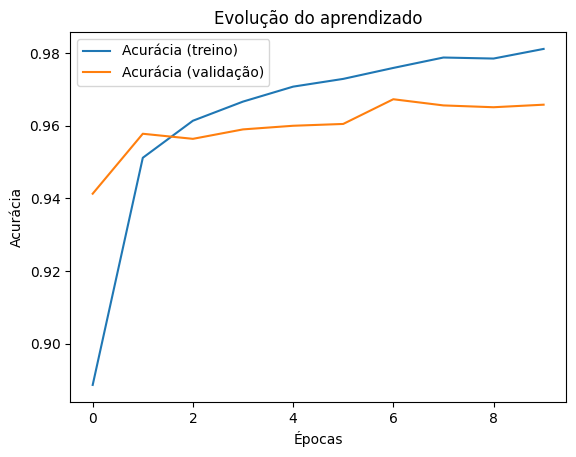

In [34]:

plt.plot(history.history['accuracy'], label='Acurácia (treino)')
plt.plot(history.history['val_accuracy'], label='Acurácia (validação)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.title('Evolução do aprendizado')
plt.legend()
plt.show()


## Avaliando o modelo

Depois que o treinamento termina, é hora de verificar **como o modelo se sai em dados totalmente novos**.  
Essa etapa é chamada de **avaliação** e serve para medir a capacidade real da rede de generalizar o que aprendeu.

Durante o treino, o modelo já viu exemplos dos dígitos várias vezes — então, ele pode ter “decorado” parte das relações.  
A avaliação com o conjunto de **teste** garante que medimos o desempenho sobre imagens que o modelo **nunca viu antes**.

---

### Diferença entre treino, validação e teste

- **Treino (training set)** → usado para ajustar os pesos da rede e ensinar o modelo.  
- **Validação (validation set)** → usado durante o treinamento apenas para acompanhar o progresso, ajudando a identificar quando o modelo começa a superajustar.  
- **Teste (test set)** → usado **apenas no final**, para avaliar o desempenho final do modelo em dados novos.

---

### Avaliando na prática

```python
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Acurácia no conjunto de teste: {test_acc:.4f}")
```

Esse comando executa o modelo em todas as imagens do conjunto de teste e calcula:

- **Perda (loss)**: representa o erro médio das previsões.  
- **Acurácia (accuracy)**: mostra o percentual de acertos do modelo.

---

### Interpretando o resultado

Uma acurácia alta (acima de 0.90, por exemplo) indica que o modelo conseguiu **aprender bem os padrões** do conjunto de dados e está **generalizando adequadamente**.  
Se a acurácia de teste for muito menor que a de treino, o modelo pode ter **superajustado** — ou seja, aprendido demais sobre os exemplos específicos de treino, perdendo a capacidade de generalizar.

In [35]:

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Acurácia no conjunto de teste: {test_acc:.4f}")


313/313 - 1s - 2ms/step - accuracy: 0.9658 - loss: 0.1261
Acurácia no conjunto de teste: 0.9658


## Visualizando previsões

Agora que o modelo foi treinado e avaliado, podemos **ver na prática** como ele realiza as classificações.  
Cada imagem do conjunto de teste é enviada para a rede, que retorna **10 probabilidades** — uma para cada dígito (de 0 a 9).  
O número com a maior probabilidade é considerado a **previsão final** do modelo.

---

### Como funciona internamente

- A última camada da rede usa a função **softmax**, que transforma as saídas em **probabilidades que somam 1**.  
- Assim, o modelo não apenas diz “qual número ele acha que é”, mas também **o quanto ele tem confiança** nessa resposta.  
- Por exemplo, uma previsão pode indicar:
  ```
  [0.01, 0.02, 0.88, 0.03, 0.06, 0.00, 0.00, 0.00, 0.00, 0.00]
  ```
  Nesse caso, o modelo prevê que a imagem representa o número **2**, com 88% de confiança.

---

### Visualizando as previsões

O código abaixo mostra algumas imagens do conjunto de teste com suas previsões e valores reais:

```python
predictions = model.predict(x_test)

def plot_prediction(i):
    plt.imshow(x_test[i].reshape(28,28), cmap='gray')
    plt.title(f"Previsto: {np.argmax(predictions[i])} | Real: {y_test[i]}")
    plt.axis('off')
    plt.show()

for i in range(5):
    plot_prediction(i)
```

---

### Interpretando os resultados

Ao observar as imagens:
- Se o valor previsto for igual ao valor real, significa que o modelo **reconheceu corretamente o dígito**.  
- Quando houver erro, é interessante analisar se o dígito era difícil até mesmo para um humano (por exemplo, 4 e 9 mal escritos).  
- Essa etapa ajuda a perceber **onde o modelo ainda confunde padrões**, fornecendo pistas para possíveis melhorias (mais camadas, mais dados ou mais épocas).

---

Essa visualização torna o aprendizado mais concreto, permitindo “ver” o que a rede aprendeu e como ela toma decisões.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


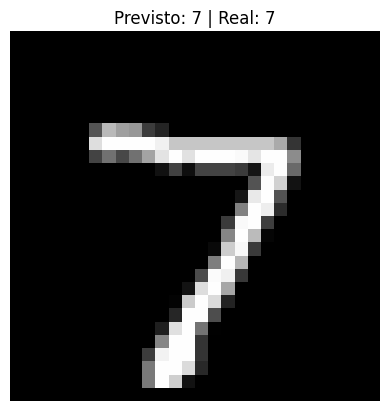

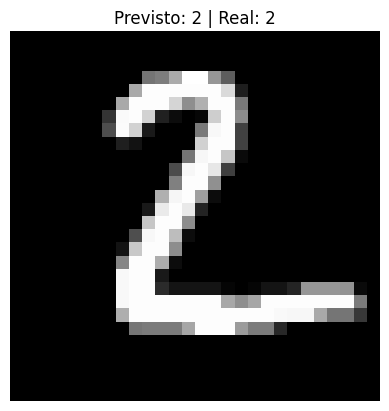

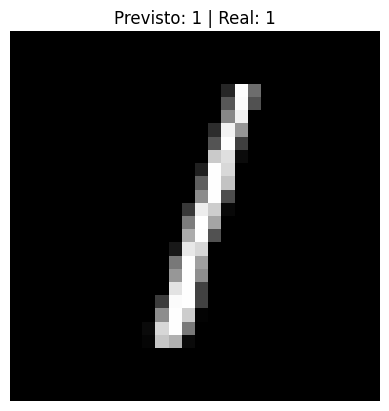

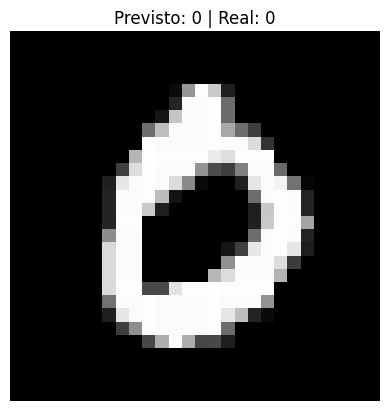

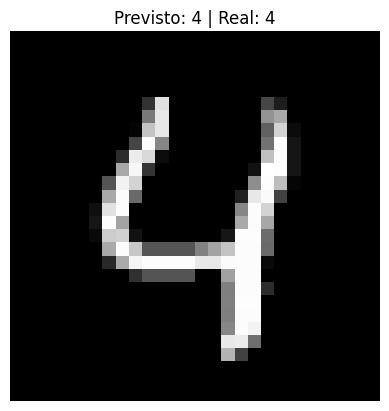

In [36]:

predictions = model.predict(x_test)

def plot_prediction(i):
    plt.imshow(x_test[i].reshape(28,28), cmap='gray')
    plt.title(f"Previsto: {np.argmax(predictions[i])} | Real: {y_test[i]}")
    plt.axis('off')
    plt.show()

for i in range(5):
    plot_prediction(i)



## Conclusão

Nesta atividade, construímos um MLP usando TensorFlow e Keras, explorando:
- A estrutura multicamada do Perceptron;
- O processo de treinamento com retropropagação;
- A importância das funções de ativação e do gradiente descendente;
- A capacidade do modelo de aprender padrões complexos (no caso, reconhecer dígitos manuscritos).

Esse mesmo raciocínio pode ser aplicado a outros problemas de classificação — basta adaptar os dados e o número de saídas.


## Exercícios práticos

Agora que você construiu e treinou um MLP para reconhecer dígitos do MNIST, é hora de **explorar o comportamento do modelo** e observar como as escolhas de arquitetura afetam o resultado.

### 1️⃣ Variação de camadas e neurônios
Crie novos modelos modificando:
- O **número de camadas ocultas** (tente usar 1, 2 ou 3 camadas);
- O **número de neurônios** em cada camada (por exemplo, 32, 64, 128, 256).

Treine cada modelo e **compare a acurácia final** e o tempo de treinamento.

> 💡 *Dica:* redes maiores tendem a aprender mais, mas também podem demorar mais e correr o risco de “decorar” os dados (overfitting).

---

### 2️⃣ Funções de ativação
Troque a função de ativação `relu` por outras, como:
```python
activation='sigmoid'
```
ou
```python
activation='tanh'
```

Observe como isso influencia:
- A **velocidade de aprendizado** (as curvas sobem mais devagar ou mais rápido?);
- A **acurácia final** do modelo.

---

### 3️⃣ Número de épocas
Mude o número de épocas no treinamento:
```python
model.fit(x_train, y_train, epochs=5, ...)
```
ou
```python
model.fit(x_train, y_train, epochs=20, ...)
```

Compare as curvas de treino e validação para identificar quando o modelo **começa a parar de melhorar** ou **superajusta**.

---

### 4️⃣ Avaliação visual
Escolha algumas imagens em que o modelo errou e tente entender **por que** ele se confundiu.  
Você pode usar o código abaixo como ponto de partida:

```python
for i in range(100):
    pred = np.argmax(predictions[i])
    real = y_test[i]
    if pred != real:
        plt.imshow(x_test[i].reshape(28,28), cmap='gray')
        plt.title(f"Previsto: {pred} | Real: {real}")
        plt.axis('off')
        plt.show()
        break
```

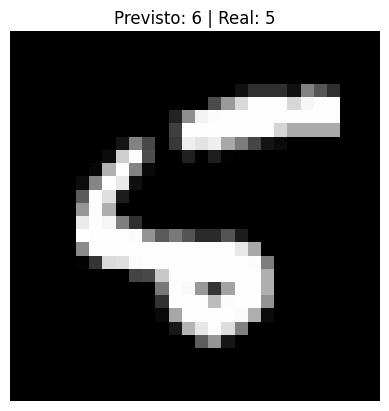

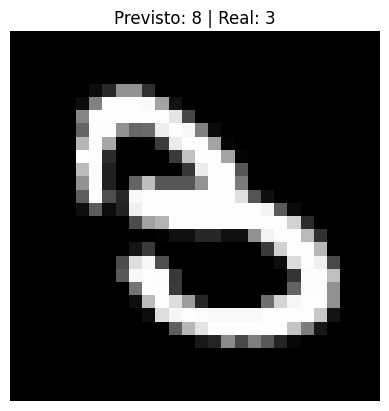

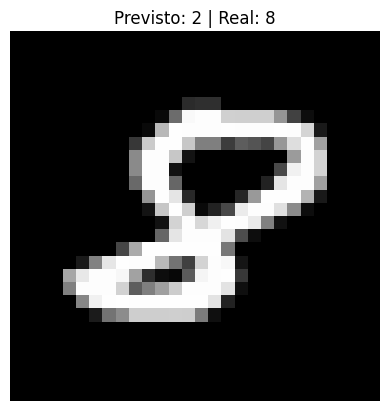

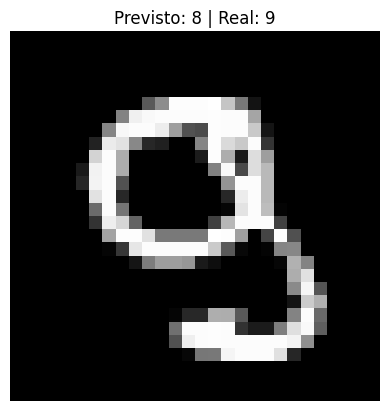

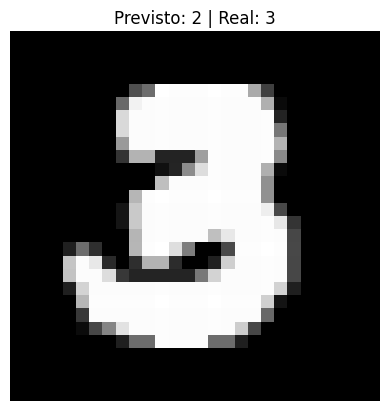

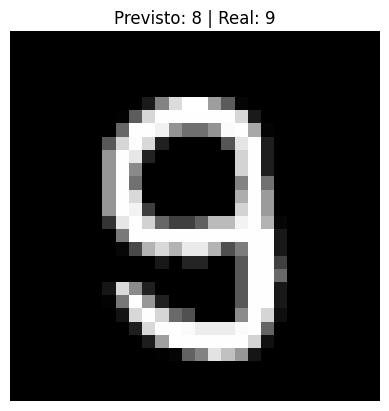

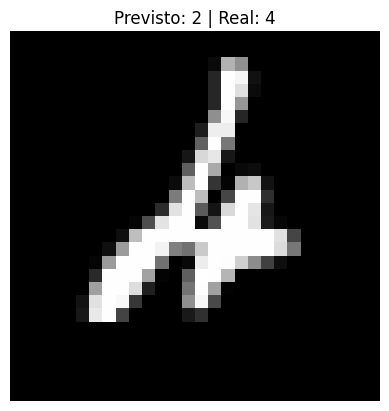

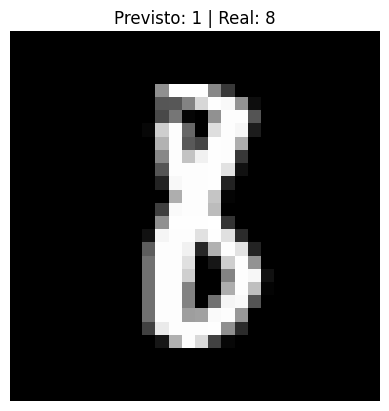

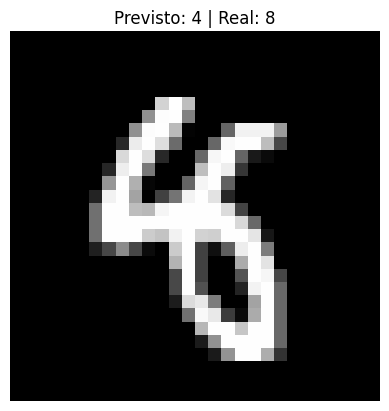

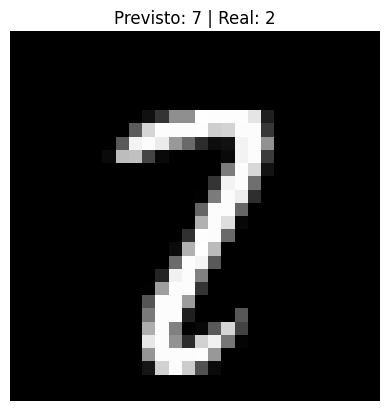

In [39]:
erros = 0
for i in range(len(x_test)):
    pred = np.argmax(predictions[i])
    real = y_test[i]
    if pred != real:
        plt.imshow(x_test[i].reshape(28,28), cmap='gray')
        plt.title(f"Previsto: {pred} | Real: {real}")
        plt.axis('off')
        plt.show()
        erros += 1
        if erros == 10:
            break


O modelo se confunde porque alguns dígitos escritos à mão são muito parecidos visualmente, como 8 e 9 ou 4 e 2. Além disso, o MLP não entende bem padrões espaciais, analisando os pixels de forma mais simples, o que dificulta reconhecer formas humanas variadas. O desempenho também pode ser limitado por poucas épocas de treino ou baixa complexidade do modelo